In [1]:
import os
import numpy as np
import xarray as xr
import numpy as np
# import cartopy.crs as ccrs
# import cartopy.feature as feat
from scipy import constants as co
from scipy import fft
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import IPython.display as disp
# import metpy.interpolate as intp
import pandas as pd
import time
# from ipywidgets import IntProgress, HTML
import shutil

In [2]:
DATADIR = "/scratch2/hugo/ERA5"
CLIMSTOR = "/mnt/climstor/ecmwf/era5/raw"

def filenamescm(y, m, d):  # Naming conventions of the files on climstor (why are they so different?)
    return [f"{CLIMSTOR}/ML/data/{str(y)}/P{str(y)}{str(m).zfill(2)}{str(d).zfill(2)}_{str(h).zfill(2)}" for h in range(0, 24, 6)]
def filenamecp(y, m, d):
    return [f"{CLIMSTOR}/PL/data/an_pl_ERA5_{str(y)}-{str(m).zfill(2)}-{str(d).zfill(2)}.nc"]  # returns iterable to have same call signature as filenamescl(y, m, d)
def filenamegeneric(folder, y, m):
    return f"{DATADIR}/{folder}/{y}{str(m).zfill(2)}.nc"

def fncm(date):  # instead takes pandas.timestamp as input
    return filenamescm(date.year, date.month, date.day)
def fncp(date):
    return filenamecp(date.year, date.month, date.day)
def fngeneric(folder, date):
    return filenamegeneric(folder, date.year, date.month)

RADIUS = 6.371e6  # m
OMEGA = 7.2921e-5  # rad.s-1
KAPPA = 0.2854
R_SPECIFIC_AIR = 287.0500676

def degcos(x):
    return np.cos(x / 180 * np.pi)
def degsin(x):
    return np.sin(x / 180 * np.pi)

DATERANGEPL = pd.date_range("19590101", "20211231")
YEARSPL = np.unique(DATERANGEPL.year)
DATERANGEML = pd.date_range("19770101", "20211231")

In [3]:
longname = {
    "u": "U-component of wind",
    "v": "V-component of wind",
    "w": "W-component of wind",
    "z": "Geopotential",
    "t": "Temperature",
    "vo": "Relative vorticity",
    "q": "Specific humidity",
    "r": "relative humidity"
    
}
variablemap = {
    f"{var}{lev}": [var, "PL", lev, f"{longname[var]} at {lev} hPa"] 
    for var in ["u", "v", "vo"] 
    for lev in range(700, 901, 50)
}
var = "z"
vm2 = {
    f"{var}{lev}": [var, "PL", lev, f"{longname[var]} at {lev} hPa"] 
    for lev in [300, 500]
}

variablemap.update(vm2)
variablemap["t850"] = ["t", "PL", 850, f"{longname['t']} at 850 hPa"]

In [6]:
# create yearly files containing u(700-75-925), compliant with Barripedro et. al (2022); Woollings (2010)

# f1 = IntProgress(min=0, max=len(YEARSPL) * 12)
# display(f1)
for year in YEARSPL:
    for month in range(1, 13):
        fn = filenamegeneric("Woollings", year, month)
        if os.path.isfile(fn):
            # f1.value += 1
            continue
        to_merge = []
        for d in DATERANGEPL[np.logical_and(DATERANGEPL.year == year, DATERANGEPL.month == month)]:    
            to_merge.extend(fncp(d))
        xr.open_mfdataset(
            to_merge, 
            drop_variables=[v for v in longname if v != "u"], 
            engine="scipy",
        ).sel(
            level=[700.0, 750.0, 800.0, 850.0, 900.0]
        ).to_netcdf(fn)
        # f1.value += 1

### JLI computations on scratch/ERA5/Wind/ files, following Woollings et al. 2010 

In [15]:
# Step 1 : extraction of daily mean zonal wind, averaged over 4 p levels
files = [filenamegeneric("Wind3", y, m) for y in YEARSPL for m in range(1, 13)]
da = xr.open_mfdataset(files, concat_dim=["time"], combine='nested', engine="netcdf4")["u"]

In [23]:
# Step 3 : Lanczos filtering
def low_pass_weights(window, cutoff):  # shamefully stolen from https://github.com/liv0505/Lanczos-Filter
    """Calculate weights for a low pass Lanczos filter.
    Args:
    window: int
        The length of the filter window.
    cutoff: float
        The cutoff frequency in inverse time steps.
    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

weights = xr.DataArray(low_pass_weights(61, 1 / 10), dims=["window"])
da2 = da.rolling(time=len(weights), center=True).construct("window").dot(weights).isel(time=range(30, len(da.time) - 30))

In [24]:
JL = da2.argmax(dim="lat", skipna=True).load()
JLI = da2.lat[JL][:, 0]
JLS = da2.isel(lat=JL)[:, 0]
JLIsmooth = JLI.groupby("time.dayofyear").mean(dim="time")

HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 30:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
    major: Attribute
    minor: Unable to initialize object
  #005: H5Oattribute.c line 476 in H5O__attr_open_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #006: H5Adense.c line 394 in H5A__dense_open(): can't locate attribute in name index
    major: Attribute
    minor: Object not

In [25]:
ft = fft.rfft(JLIsmooth.values)
ft[1:] = 0
JLIsmooth2 = xr.DataArray(fft.irfft(ft, len(JLIsmooth)), dims=JLIsmooth.dims)


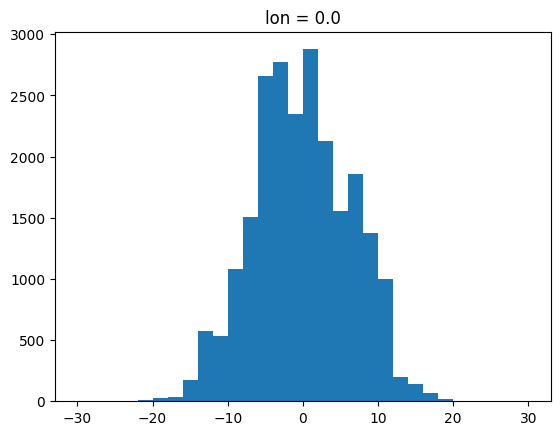

In [26]:
hist = xr.plot.hist(JLI.groupby("time.dayofyear") - JLIsmooth2, bins=np.arange(-30, 31, 2))

### PV calculation on a ML file from climstor

In [ ]:
ds = xr.open_dataset(fncm(DATERANGEML[0])[0])

In [ ]:
ds["T"] = ds["T"] + 287.15
ds["T"].attrs["units"] = "K"

ds["PS"] = 1e2 * ds["PS"]
ds["PS"].attrs["units"] = "Pa"

ds["SIGMA"] = (ds["V"].differentiate("lon") - (ds["U"] * degcos(ds["lat"])).differentiate("lat")) / RADIUS / degcos(ds["lat"])
ds["SIGMA"][:, :, [0, -1], :] = 0
ds["SIGMA"].attrs["units"] = "1/s"

ds["OMEGA"] = ds["SIGMA"] + 2 * OMEGA * degsin(ds["lat"])
ds["OMEGA"].attrs["units"] = "1/s"

ds["P"] = ({key: len(ds[key]) for key in ds["T"].dims}, (np.tensordot(
    ds["hybm"].values, ds["PS"][:, 0, :, :].values, axes=0
    ) + ds["hyam"].values[:, np.newaxis, np.newaxis, np.newaxis]).reshape(ds["T"].shape))
ds["P"].attrs["units"] = "Pa"

ds["THETA"] = ds["T"] * (ds["PS"].values[:, 0, np.newaxis, :, :] / ds["P"].values) ** KAPPA
ds["THETA"].attrs["units"] = "K"

ds["RHO"] = ds["P"] / R_SPECIFIC_AIR / ds["T"]
ds["RHO"].attrs["units"] = "kg/m3"

ds["PV"] = 1e-6 * ds["OMEGA"] * ds["THETA"].differentiate("lev") / ds["P"].differentiate("lev") / ds["RHO"]
ds["PV"].attrs["units"] = "PVU"
ds["PV"][:, :, 180:, :] = -ds["PV"][:, :, 180:, :]

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=[20, 20])
axes = axes.flatten()
k = 0
for l in range(0, 137, 1 + int(137/20)):
    ds["PV"][0, l, :, :].plot(ax=axes[k])
    k += 1

In [ ]:
def create_plot(to_plot, titles, levels, twolevel=False, startindex=-1):
    # Figure
    transform = ccrs.PlateCarree()
    projection = transform
    if twolevel:
        fig, axes = plt.subplots(
            2,
            int(len(to_plot) / 2),
            subplot_kw={"projection": projection}, constrained_layout=True #, figsize=(6 * len(to_plot) // 2, 13)
        )
    else:
        fig, axes = plt.subplots(
            1, len(to_plot), subplot_kw={"projection": projection}, constrained_layout=True
        )
    axes = np.atleast_1d(axes)
    axes = axes.flatten()

    # Add coastline and boarders
    coastline = feat.NaturalEarthFeature(
        "physical", "coastline", "10m", edgecolor="black", facecolor="none"
    )
    borders = feat.NaturalEarthFeature(
        "cultural",
        "admin_0_boundary_lines_land",
        "10m",
        edgecolor="grey",
        facecolor="none",
    )
    plt_rej = []
    cbar = [None] * len(to_plot)
    for j in range(len(to_plot)):
        ax = axes[j]
        plt_rej.append(
            ax.contourf(
                to_plot[j]["lon"],
                to_plot[j]["lat"],
                to_plot[j].isel(time=startindex),
                levels=levels[j],
                transform=transform,
                transform_first=True,
                # cmap=cmap,
                zorder=0,
            )
        )

        ax.add_feature(coastline)
        ax.add_feature(borders)
        ax.set_xmargin(0)
        ax.set_ymargin(0)
        ax.set_title(f"Day {startindex}, {titles[j]}, g.a : {np.mean(to_plot[j][startindex]):.2f}")

        cbar[j] = fig.colorbar(plt_rej[j], ax=ax,fraction=0.046, pad=0.04)

    def animate_all(i):
        global plt_rej
        for j in range(len(to_plot)):
            ax = axes[j]
            for c in plt_rej[j].collections:
                c.remove()
            plt_rej[j] = ax.contourf(
                to_plot[j]["lon"],
                to_plot[j]["lat"],
                to_plot[j].isel(time=i),
                levels=levels[j],
                transform=transform,
                transform_first=True,
                # cmap=cmap,
                zorder=0,
            )
            ax.set_title(f"Day {i + 1}, {titles[j]}, g.a : {np.mean(to_plot[j][i]):.2f}")
            cbar[j] = fig.colorbar(plt_rej[j], cax=fig.axes[len(axes) + j])
        return plt_rej

    return fig, axes, plt_rej, animate_all